In [0]:
#Importando bibliotecas

from pyspark.sql import functions as F
from pyspark.sql.functions import avg, sum as _sum, count, min as _min, max as _max, datediff
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import stats, ttest_ind, chi2_contingency, shapiro, mannwhitneyu

In [0]:
#Importando bases de clientes
user_orders = spark.table('workspace.tabelas_ifood.user_orders')
consumer = spark.table('workspace.tabelas_ifood.consumer').dropDuplicates()
ab_ref = spark.table('workspace.tabelas_ifood.ab_test_ref').dropDuplicates()

In [0]:
# Checando distribuição dos grupos de teste e controle
consumer_groups = consumer.join(ab_ref, on='customer_id')
consumer_groups = consumer_groups.toPandas() #Conversão em pandas dataframe para análises estatísticas

In [0]:
consumer_groups

,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target
0,5c71cf8f3f4e490c1fc36f8c09386156bc3bbbf359574a...,pt-br,2018-01-05 01:13:04.670,True,MARCEL,6,744468121,target
1,06ed1101a1809874583017dda9b47bace2b1c483587832...,pt-br,2018-04-06 03:32:15.666,True,TITO,95,807741523,target
2,5d16e9a8e39616c7a7100191a27261e76be3179f774df7...,pt-br,2018-01-06 16:57:20.477,True,VAGNER,37,74979169,target
3,f4d8960dbad9c3d02664316639e525effe6274dd9a9830...,pt-br,2018-04-06 05:06:31.818,True,ISABELA,68,471876071,control
4,c12f39c32a93e001554abae73b418ff563e7a41b392cdf...,pt-br,2018-03-01 16:05:26.848,True,JOÃO,16,232076216,target
...,...,...,...,...,...,...,...,...
806151,73014a25f96e6164a7c90414b9c7be1e416d234c6e5da9...,pt-br,2018-04-06 05:11:12.946,False,PAULA,11,263977608,target
806152,7be7a5605a00d1cc5156c35acd62deef1e6cc5c927d1b1...,pt-br,2018-01-07 15:32:20.918,True,BRENO,11,610963163,target
806153,e008f32032a86f8d112d1d5736ba65913ea228b726aeee...,pt-br,2018-01-03 15:43:11.316,True,PATRICIA,1,944410685,target
806154,ad8d97e569d12c3fa6172405a474c594f0bfd074ae949a...,pt-br,2018-01-03 23:28:27.475,True,DANY,28,712735950,control


In [0]:
consumer_groups['customer_phone_area'] = consumer_groups['customer_phone_area'].astype('string')
consumer_groups['customer_phone_area'].value_counts()

60    8268
61    8223
56    8201
62    8199
12    8197
      ... 
17    7921
92    7921
38    7915
48    7903
0     7324
Name: customer_phone_area, Length: 100, dtype: Int64

In [0]:
consumer_groups['language'].value_counts()

pt-br    806154
es-ar         2
Name: language, dtype: int64

In [0]:
consumer_groups['active'] = consumer_groups['active'].astype('string')
consumer_groups['active'].value_counts()

True     804561
False      1595
Name: active, dtype: int64

In [0]:
# Checando uniformidade da distribuição pelas variáveis de área telefônica e atividade 

contingency_table = pd.crosstab(consumer_groups['is_target'], consumer_groups['customer_phone_area'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi² statistic: {chi2}")
print(f"p-valor: {p}")

Chi² statistic: 122.10012929258038
p-valor: 0.05757133692513383


In [0]:
contingency_table = pd.crosstab(consumer_groups['is_target'], consumer_groups['active'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi² statistic: {chi2}")
print(f"p-valor: {p}")

Chi² statistic: 0.0
p-valor: 1.0


In [0]:
#Analisando dados de pedidos agendados
display(user_orders.filter((F.col('order_scheduled') == True) & (F.col('order_scheduled_date') > F.col('order_created_at'))))

merchant_id,customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,is_target,user_months,order_id,order_created_at,delivery_address_city,delivery_address_state,origin_platform,order_total_amount,item_count,garnish_count,restaurant_created_at,enabled,price_range,average_ticket,takeout_time,delivery_time,minimum_order_value,merchant_zip_code,merchant_city,merchant_state,merchant_country


In [0]:
#As datas de entrega de pedidos agendados não fazem sentido em relação às datas de criação, logo serão desconsiderados
user_orders = user_orders.filter(user_orders['order_scheduled'] != True)
user_orders = user_orders.drop('order_scheduled','order_scheduled_date')

In [0]:
# Criando KPIs para avaliação do teste
user_orders = user_orders.fillna(0)
user_orders_metrics = user_orders.groupBy('customer_id','created_at','active','is_target','user_months').agg(
    avg('item_count').alias('avg_item_count'),
    _sum('item_count').alias('sum_items'),
    avg('order_total_amount').alias('avg_order_amount'),
    _sum('order_total_amount').alias('sum_total_amount'),
    count('order_id').alias('order_count'),
    _min('order_created_at').alias("first_order"),
    _max('order_created_at').alias("last_order")
)

user_orders_metrics = user_orders_metrics.withColumn(
    "days_between_orders", datediff("last_order", "first_order")
)

user_orders_metrics_pd = user_orders_metrics.toPandas()

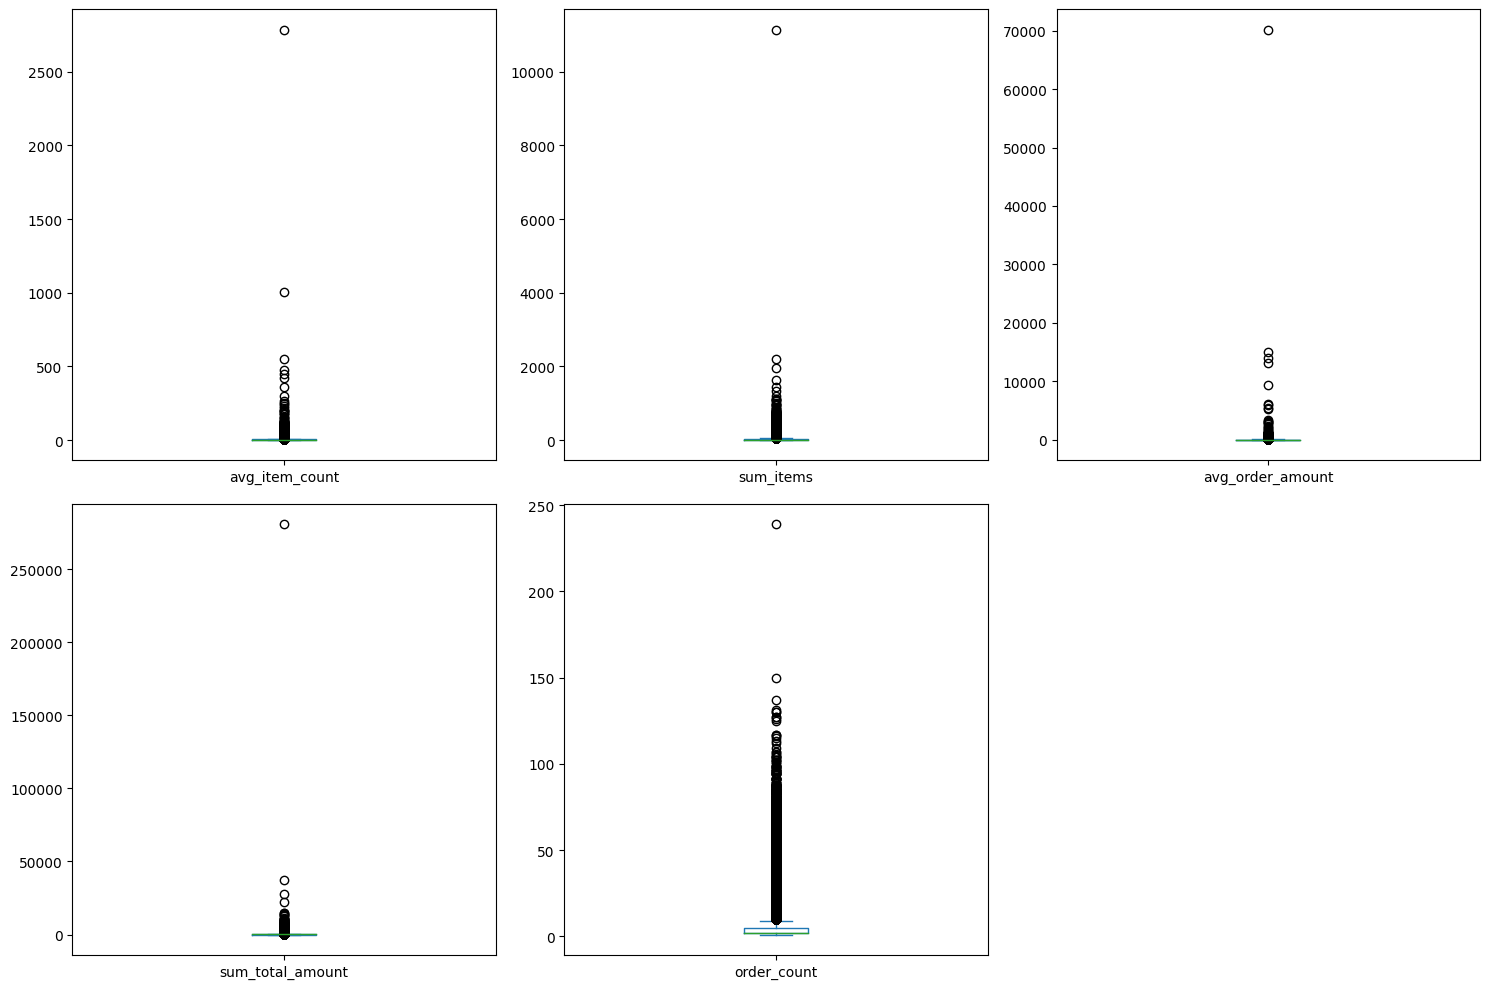

In [0]:
#Checando se há outliers
boxplot_columns = ['avg_item_count', 'sum_items', 'avg_order_amount', 'sum_total_amount', 'order_count']
user_orders_metrics_pd[boxplot_columns].plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 10))
plt.tight_layout()
plt.show()

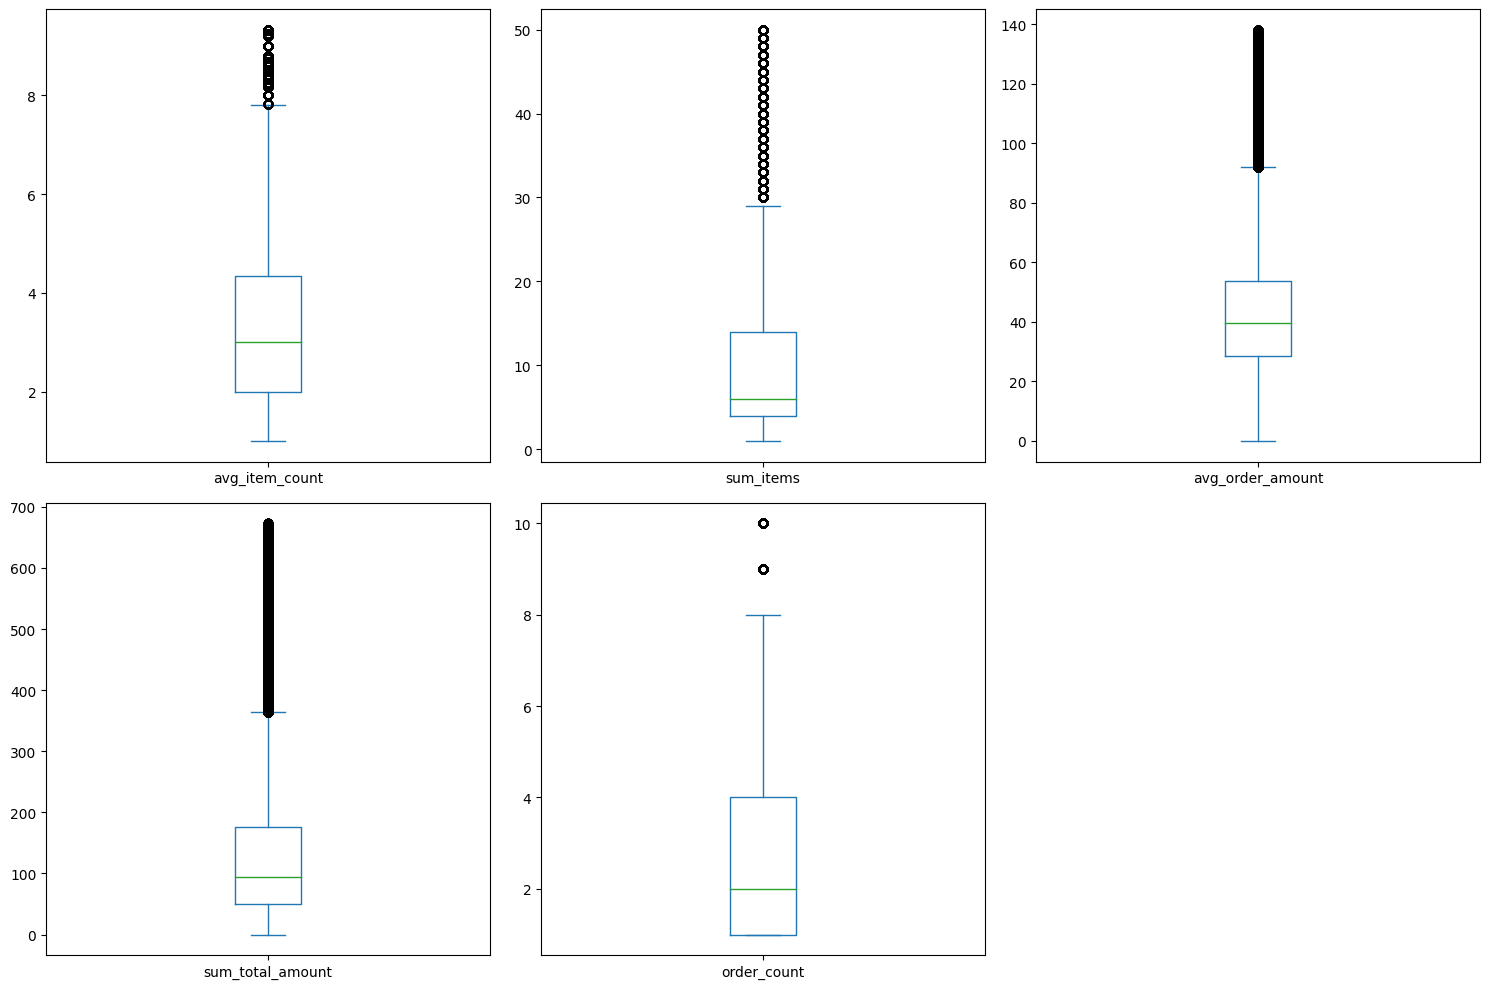

In [0]:
#Removendo outliers e checando resultado
user_orders_metrics_pd = user_orders_metrics_pd[(np.abs(stats.zscore(user_orders_metrics_pd[boxplot_columns])) < 1).all(axis=1)]

user_orders_metrics_pd[boxplot_columns].plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 10))
plt.tight_layout()
plt.show()

In [0]:
#Dividindo grupos de teste para comparação
df_target = user_orders_metrics_pd[user_orders_metrics_pd['is_target'] == 'target']
df_control = user_orders_metrics_pd[user_orders_metrics_pd['is_target'] == 'control']

In [0]:
#Fazendo teste de Shapiro para verificar se as variáveis seguem uma distribuição normal
stat, p_value = shapiro(df_target['order_count'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.8407, p-value: 0.0000


In [0]:
stat, p_value = shapiro(df_target['days_between_orders'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.8706, p-value: 0.0000


In [0]:
stat, p_value = shapiro(df_target['order_count_normal'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.8407, p-value: 0.0000


In [0]:
stat, p_value = shapiro(df_target['sum_total_amount'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.8381, p-value: 0.0000


In [0]:
stat, p_value = shapiro(df_target['avg_order_amount'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.9184, p-value: 0.0000


In [0]:
stat, p_value = shapiro(df_target['avg_item_count'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.9208, p-value: 0.0000


In [0]:
stat, p_value = shapiro(df_target['sum_items'].dropna())
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk test statistic: 0.8303, p-value: 0.0000


In [0]:
# Como nenhuma das variáveis segue uma distribuição normal, vamos utilizar o teste de Mann-Whitney para comparação dos grupos
stat, p_val = mannwhitneyu(
    df_target['order_count'].dropna(),
    df_control['order_count'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U test para order_count (p-valor): {p_val:.4f}")

Mann-Whitney U test para order_count (p-valor): 0.0000


In [0]:
stat, p_val = mannwhitneyu(
    df_target['sum_total_amount'].dropna(),
    df_control['sum_total_amount'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U test para sum_total_amount (p-valor): {p_val:.4f}")

Mann-Whitney U test para sum_total_amount (p-valor): 0.0000


In [0]:
stat, p_val = mannwhitneyu(
    df_target['avg_order_amount'].dropna(),
    df_control['avg_order_amount'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U test para avg_order_amount (p-valor): {p_val:.4f}")

Mann-Whitney U test para avg_order_amount (p-valor): 0.0007


In [0]:
stat, p_val = mannwhitneyu(
    df_target['sum_items'].dropna(),
    df_control['sum_items'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U test para sum_items (p-valor): {p_val:.4f}")

Mann-Whitney U test para sum_items (p-valor): 0.0000


In [0]:
stat, p_val = mannwhitneyu(
    df_target['avg_item_count'].dropna(),
    df_control['avg_item_count'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U test para avg_item_count (p-valor): {p_val:.4f}")

Mann-Whitney U test para avg_item_count (p-valor): 0.0000


In [0]:
stat, p_val = mannwhitneyu(
    df_target['days_between_orders'].dropna(),
    df_control['days_between_orders'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U test para avg_item_count (p-valor): {p_val:.4f}")

Mann-Whitney U test para avg_item_count (p-valor): 0.0000


In [0]:
# Estasticamente, não há diferença significativa de parâmetros de sucesso entre os dois grupos